In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
import keras_tuner as kt
from joblib import dump, load
import graphviz



In [2]:
# Connect to DB and import data into a pandas dataframe
connection = sqlite3.connect('../data/db.sqlite')
ratings = pd.read_sql_query("SELECT * FROM ratings", connection)
clean = pd.read_sql_query("SELECT * FROM clean", connection)
dummies = pd.read_sql_query("SELECT * FROM dummies", connection)
clean2 = pd.read_sql_query("SELECT * FROM clean2", connection)
dummies2 = pd.read_sql_query("SELECT * FROM dummies2", connection)

connection.close()

## Neural Network Machine Learning

In [3]:
# Deep Learning Model Function
def preprocess_data(df):
    X = dummies.drop(['Binary Rating'], axis=1)
    y = dummies['Binary Rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

def build_model(X_train_scaled, num_layers, first_layer_neurons, middle_layer_neurons, last_layer_neurons, first_layer_activation, middle_layer_activation, last_layer_activation):
    number_input_features = len(X_train_scaled[0])
    nn = tf.keras.models.Sequential()
    # First layer
    nn.add(tf.keras.layers.Dense(units=first_layer_neurons, input_dim=number_input_features, activation=first_layer_activation))
    # Middle layers
    for _ in range(num_layers - 2):
        nn.add(tf.keras.layers.Dense(units=middle_layer_neurons, activation=middle_layer_activation))
    # Last layer
    nn.add(tf.keras.layers.Dense(units=last_layer_neurons, activation=last_layer_activation))
    nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn

def train_model(nn, X_train_scaled, y_train, EPOCHS):
    mini_path = f'../models/model{model}/checkpoints/'
    checkpoint_filepath = mini_path + 'weights.epoch_{epoch:02d}.hdf5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_freq=5,
        verbose=True)
    fit_model = nn.fit(X_train_scaled, y_train, epochs=EPOCHS, callbacks=[model_checkpoint_callback])
    return fit_model

def evaluate_model(nn, X_test_scaled, y_test):
    model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
    print(f"Model {model}-- Loss: {model_loss}, Accuracy: {model_accuracy}")
    predictions = nn.predict(X_test_scaled)
    predictions = np.argmax(predictions, axis=1)
    cm = confusion_matrix(y_test, predictions)
    return cm

def plot_confusion_matrix(cm, model):
    sns.set()
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig(f'../img/models/deeplearning/model{model}_confusion_matrix.png')
    plt.show()

def save_model_plot(nn, model):
    plot_model(nn, to_file=f'../img/models/deeplearning/model{model}_plot.png', show_shapes=True, show_layer_names=True)

def save_model(nn, model):
    nn.save(f'../models/deeplearning/model{model}/model.h5')




Running it

Epoch 1/75


2024-03-24 11:17:18.061187: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/183 [..............................] - ETA: 39s - loss: 0.5872 - accuracy: 0.8750
Epoch 1: saving model to ../models/model1/checkpoints/weights.epoch_01.hdf5

Epoch 1: saving model to ../models/model1/checkpoints/weights.epoch_01.hdf5

Epoch 1: saving model to ../models/model1/checkpoints/weights.epoch_01.hdf5

Epoch 1: saving model to ../models/model1/checkpoints/weights.epoch_01.hdf5

Epoch 1: saving model to ../models/model1/checkpoints/weights.epoch_01.hdf5

Epoch 1: saving model to ../models/model1/checkpoints/weights.epoch_01.hdf5

Epoch 1: saving model to ../models/model1/checkpoints/weights.epoch_01.hdf5
 35/183 [====>.........................] - ETA: 0s - loss: 0.7334 - accuracy: 0.6661 
Epoch 1: saving model to ../models/model1/checkpoints/weights.epoch_01.hdf5

Epoch 1: saving model to ../models/model1/checkpoints/weights.epoch_01.hdf5

Epoch 1: saving model to ../models/model1/checkpoints/weights.epoch_01.hdf5

Epoch 1: saving model to ../models/model1/checkpoints/weigh

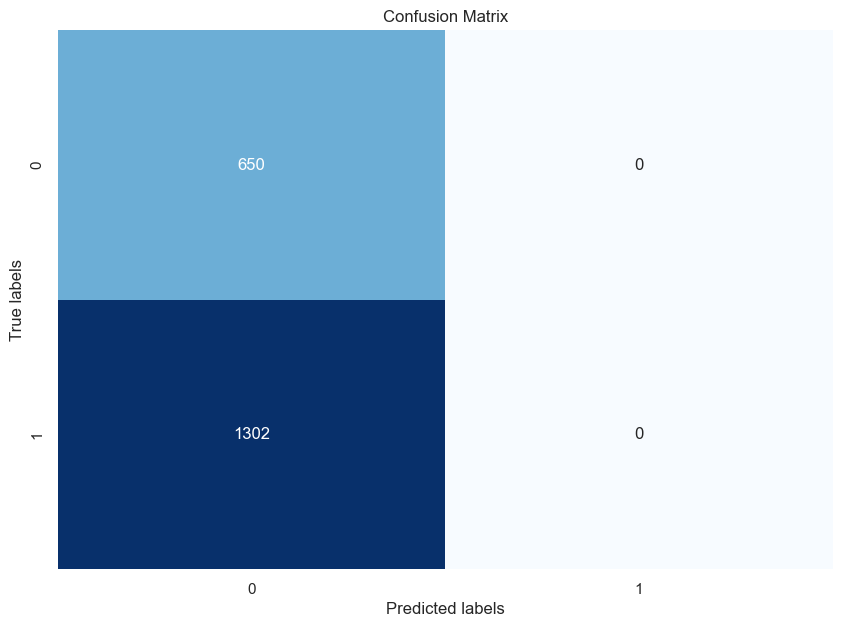

In [4]:
model = 1
data_frame = dummies
X_train_scaled, X_test_scaled, y_train, y_test = preprocess_data(data_frame)

num_layers = 3
first_layer_neurons = 4
middle_layer_neurons = 2
last_layer_neurons = 1
first_layer_activation = "relu"
middle_layer_activation = "relu"
last_layer_activation = "sigmoid"
EPOCHS = 75

nn = build_model(X_train_scaled, num_layers, first_layer_neurons, middle_layer_neurons, last_layer_neurons, first_layer_activation, middle_layer_activation, last_layer_activation)
fit_model = train_model(nn, X_train_scaled, y_train, EPOCHS)
cm = evaluate_model(nn, X_test_scaled, y_test)
plot_confusion_matrix(cm, model)
save_model_plot(nn, model)
save_model(nn, model)

Results, confusion matrix

## Random Forest Model

In [5]:
# Functions for Forest Model
def preprocess_data(df):
    X = df.drop(['Binary Rating'], axis=1)
    y = df['Binary Rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, X  

def train_random_forest(X_train_scaled, y_train, n_estimators=500, random_state=78):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    rf_model = rf_model.fit(X_train_scaled, y_train)
    return rf_model

def evaluate_random_forest(rf_model, X_test_scaled, y_test):
    predictions = rf_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, predictions)
    acc_score = accuracy_score(y_test, predictions)
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print(f"Accuracy Score: {acc_score}")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    return cm

def plot_confusion_matrix(cm, model):
    sns.set()
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.savefig(f'../img/models/random_forest/model{model}_confusion_matrix.png')
    plt.show()

def plot_feature_importances(rf_model, feature_names):
    importances = rf_model.feature_importances_
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importances_df = importances_df.sort_values(by='Importance', ascending=True)  
    plt.figure(figsize=(10, 6))
    plt.barh(importances_df['Feature'], importances_df['Importance'], color='lightgreen')
    plt.title(f"Model {model}'s Features Importances")
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.savefig(f'../img/models/random_forest/model{model}_importances_plot.png', bbox_inches='tight')
    plt.show()

def export_random_forest_tree(rf_model, X, model):
    single_tree = rf_model.estimators_[0]
    dot_data = export_graphviz(single_tree, out_file=None, 
                               feature_names=X.columns, 
                               class_names=['Class 0', 'Class 1'], 
                               filled=True, rounded=True, 
                               special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.view(filename=f'../img/models/random_forest/model{model}_random_tree')




Test

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          592           58
Actual 1           50         1252
Accuracy Score: 0.944672131147541
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       650
           1       0.96      0.96      0.96      1302

    accuracy                           0.94      1952
   macro avg       0.94      0.94      0.94      1952
weighted avg       0.94      0.94      0.94      1952



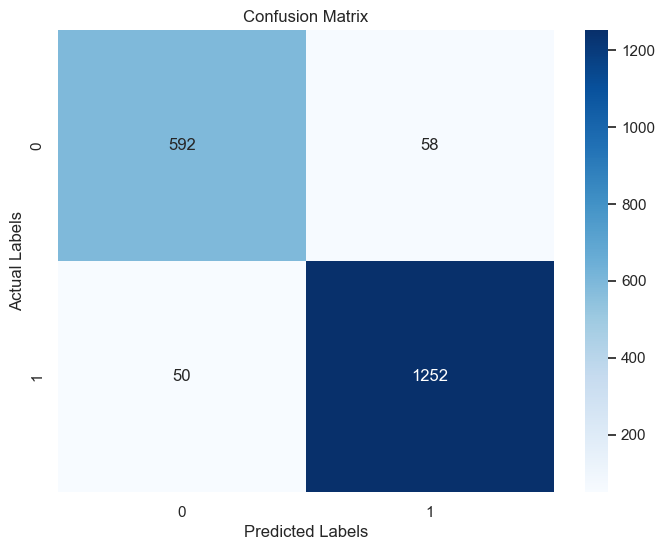

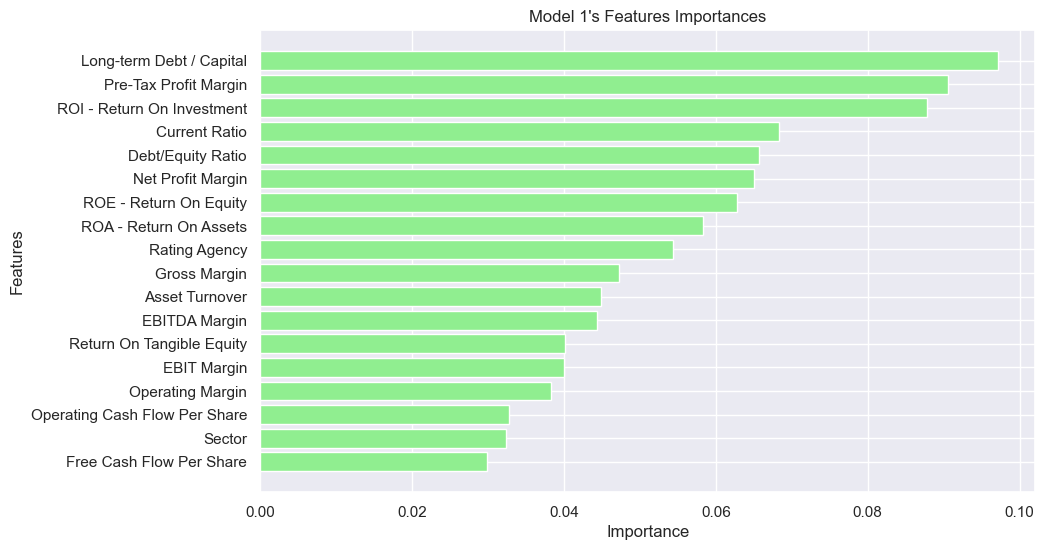

['../models/random_forest/model1.joblib']

In [6]:
model = 1
data_frame = clean
X_train_scaled, X_test_scaled, y_train, y_test, X = preprocess_data(data_frame)
rf_model = train_random_forest(X_train_scaled, y_train)
cm = evaluate_random_forest(rf_model, X_test_scaled, y_test)
plot_confusion_matrix(cm, model)
plot_feature_importances(rf_model, X.columns.tolist()) 
export_random_forest_tree(rf_model, X, model)  
dump(rf_model, f'../models/random_forest/model{model}.joblib')

Blah

## SVC

In [7]:
from sklearn.svm import SVC

def train_svc(X_train_scaled, y_train, kernel='rbf', C=1.0, gamma='scale', random_state=None):
    svc_model = SVC(kernel=kernel, C=C, gamma=gamma, random_state=random_state)
    svc_model.fit(X_train_scaled, y_train)
    return svc_model

def preprocess_data(df):
    X = df.drop(['Binary Rating'], axis=1)
    y = df['Binary Rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, X

def evaluate_svc(svc_model, X_test_scaled, y_test):
    predictions = svc_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, predictions)
    acc_score = accuracy_score(y_test, predictions)
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print(f"Accuracy Score: {acc_score}")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    return cm

def save_svc_model(svc_model, model_number):
    dump(svc_model, f'../models/svc/model{model_number}.joblib')

def svc_pipeline(data_frame, model_number, kernel='rbf', C=1.0, gamma='scale', random_state=None):
    X_train_scaled, X_test_scaled, y_train, y_test, X = preprocess_data(data_frame)
    svc_model = train_svc(X_train_scaled, y_train, kernel=kernel, C=C, gamma=gamma, random_state=random_state)
    cm = evaluate_svc(svc_model, X_test_scaled, y_test)
    plot_confusion_matrix(cm, model_number)
    plt.savefig(f'../img/models/svc/model{model_number}_confusion_matrix.png') 
    save_svc_model(svc_model, model_number)


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          416          234
Actual 1           87         1215
Accuracy Score: 0.8355532786885246
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.64      0.72       650
           1       0.84      0.93      0.88      1302

    accuracy                           0.84      1952
   macro avg       0.83      0.79      0.80      1952
weighted avg       0.83      0.84      0.83      1952



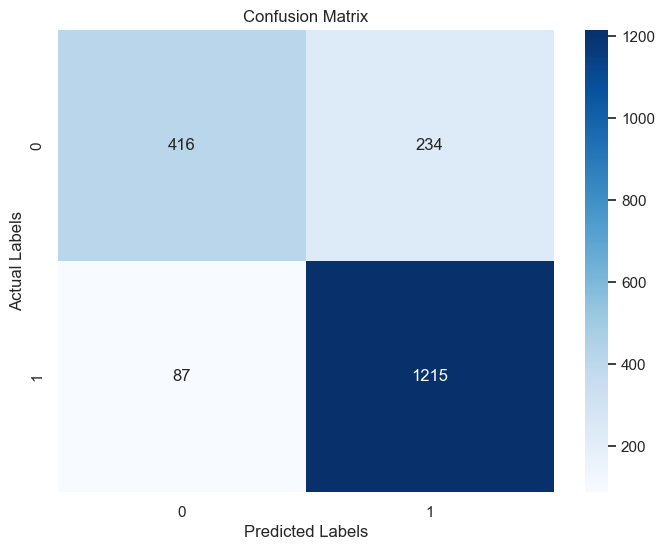

<Figure size 640x480 with 0 Axes>

In [8]:
model_number = 1
data_frame = clean
svc_pipeline(data_frame, model_number)

Blah

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

def train_gbm(X_train_scaled, y_train, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
    gbm_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    gbm_model.fit(X_train_scaled, y_train)
    return gbm_model

def evaluate_gbm(gbm_model, X_test_scaled, y_test):
    predictions = gbm_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, predictions)
    acc_score = accuracy_score(y_test, predictions)
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print(f"Accuracy Score: {acc_score}")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    return cm

def save_gbm_model(gbm_model, model_number):
    dump(gbm_model, f'../models/gbm/model{model_number}.joblib')

def gbm_pipeline(data_frame, model_number, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
    X_train_scaled, X_test_scaled, y_train, y_test, X = preprocess_data(data_frame)
    gbm_model = train_gbm(X_train_scaled, y_train, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    cm = evaluate_gbm(gbm_model, X_test_scaled, y_test)
    plot_confusion_matrix(cm, model_number)
    plt.savefig(f'../img/models/gbm/model{model_number}_confusion_matrix.png')  
    save_gbm_model(gbm_model, model_number)


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          461          189
Actual 1           87         1215
Accuracy Score: 0.8586065573770492
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       650
           1       0.87      0.93      0.90      1302

    accuracy                           0.86      1952
   macro avg       0.85      0.82      0.83      1952
weighted avg       0.86      0.86      0.86      1952



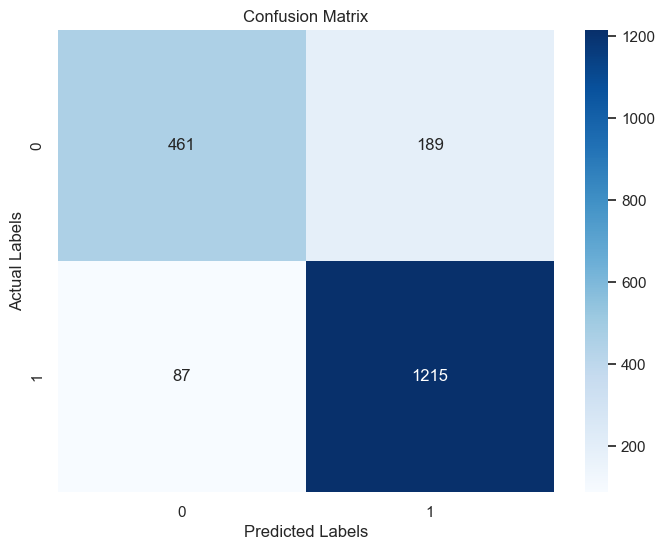

<Figure size 640x480 with 0 Axes>

In [10]:
model_number = 1
data_frame = clean
gbm_pipeline(data_frame, model_number)

Blah

## XGBoost

To install use conda install -c conda-forge py-xgboost

In [11]:
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

def train_xgboost(X_train_scaled, y_train, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
    xgb_model = xgb.XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    xgb_model.fit(X_train_scaled, y_train)
    return xgb_model

def evaluate_xgboost(xgb_model, X_test_scaled, y_test):
    predictions = xgb_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, predictions)
    acc_score = accuracy_score(y_test, predictions)
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print(f"Accuracy Score: {acc_score}")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    return cm

def save_xgboost_model(xgb_model, model_number):
    dump(xgb_model, f'../models/xgboost/model{model_number}.joblib')


def plot_confusion_matrix(cm, model_number):
    sns.set()
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted 0', 'Predicted 1'])
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('Actual Labels')
    ax.set_yticklabels(['Actual 0', 'Actual 1'], rotation=0)     
    plt.savefig(f'../img/models/xgboost/model{model_number}_confusion_matrix.png')
    plt.show()

def xgboost_pipeline(data_frame, model_number, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
    X_train_scaled, X_test_scaled, y_train, y_test, X = preprocess_data(data_frame)
    xgb_model = train_xgboost(X_train_scaled, y_train, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    cm = evaluate_xgboost(xgb_model, X_test_scaled, y_test)
    plot_confusion_matrix(cm, model_number)
    plt.savefig(f'../img/models/xgboost/model{model_number}_confusion_matrix.png') 
    save_xgboost_model(xgb_model, model_number)



Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          453          197
Actual 1           84         1218
Accuracy Score: 0.8560450819672131
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.70      0.76       650
           1       0.86      0.94      0.90      1302

    accuracy                           0.86      1952
   macro avg       0.85      0.82      0.83      1952
weighted avg       0.86      0.86      0.85      1952



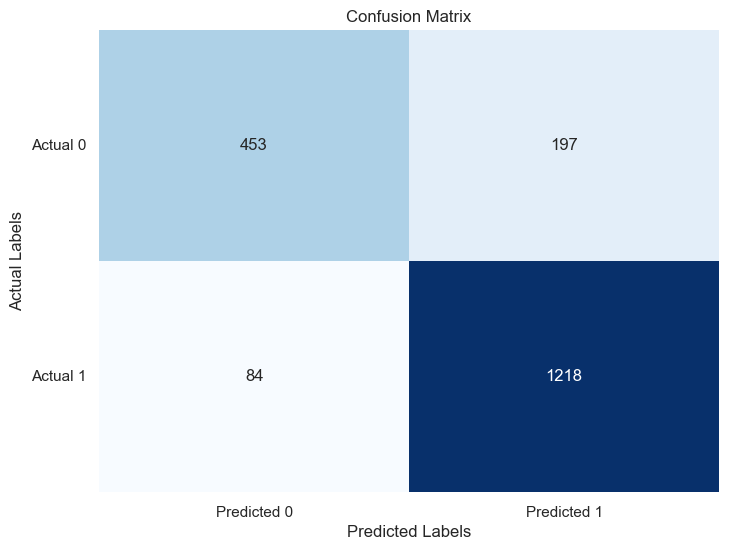

<Figure size 640x480 with 0 Axes>

In [12]:
model_number = 1
data_frame = clean
xgboost_pipeline(data_frame, model_number)

In [13]:
cm

array([[ 592,   58],
       [  50, 1252]])